# Neural Style Transfer : Myelin Foundry Challenge

We begin with importing all relevant packages 

In [1]:
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.misc
import scipy.io
from PIL import Image
import os
import sys

### Defining standard units

* Multiple layers are used for style transfer to make the generated image capture more styled features from the styling image template. This has been found to give a better mix of style and content.
* The mean values are the values which were used during the training of VGG19. This is important because the model's performance is sensitive to these values.
* All images are rescaled to 800x600 resolution.

In [2]:
style_layers = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

mean_values= np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3))

image_width = 800
image_height = 600
channels = 3

### Defining VGG19

VGG19 is used as per the author of the original paper. This architecture has been observed to give the most optimal results for this application compared to other architectures.

In [3]:
def vggmodel(path):
    vgg = scipy.io.loadmat(path)

    vgg_layers = vgg['layers']
    
    def _weights(layer, expected_layer_name):
        """
        Return the weights and bias from the VGG model for a given layer.
        """
        wb = vgg_layers[0][layer][0][0][2]
        W = wb[0][0]
        b = wb[0][1]
        layer_name = vgg_layers[0][layer][0][0][0][0]
        assert layer_name == expected_layer_name
        return W, b

        return W, b

    def _relu(conv2d_layer):
        """
        Return the RELU function wrapped over a TensorFlow layer. Expects a
        Conv2d layer input.
        """
        return tf.nn.relu(conv2d_layer)

    def _conv2d(prev_layer, layer, layer_name):
        """
        Return the Conv2D layer using the weights, biases from the VGG
        model at 'layer'.
        """
        W, b = _weights(layer, layer_name)
        W = tf.constant(W)
        b = tf.constant(np.reshape(b, (b.size)))
        return tf.nn.conv2d(prev_layer, filter=W, strides=[1, 1, 1, 1], padding='SAME') + b

    def _conv2d_relu(prev_layer, layer, layer_name):
        """
        Return the Conv2D + RELU layer using the weights, biases from the VGG
        model at 'layer'.
        """
        return _relu(_conv2d(prev_layer, layer, layer_name))

    def _avgpool(prev_layer):
        """
        Return the AveragePooling layer.
        """
        return tf.nn.avg_pool(prev_layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # Constructs the graph model.
    graph = {}
    graph['input']   = tf.Variable(np.zeros((1, image_height, image_width, channels)), dtype = 'float32')
    graph['conv1_1']  = _conv2d_relu(graph['input'], 0, 'conv1_1')
    graph['conv1_2']  = _conv2d_relu(graph['conv1_1'], 2, 'conv1_2')
    graph['avgpool1'] = _avgpool(graph['conv1_2'])
    graph['conv2_1']  = _conv2d_relu(graph['avgpool1'], 5, 'conv2_1')
    graph['conv2_2']  = _conv2d_relu(graph['conv2_1'], 7, 'conv2_2')
    graph['avgpool2'] = _avgpool(graph['conv2_2'])
    graph['conv3_1']  = _conv2d_relu(graph['avgpool2'], 10, 'conv3_1')
    graph['conv3_2']  = _conv2d_relu(graph['conv3_1'], 12, 'conv3_2')
    graph['conv3_3']  = _conv2d_relu(graph['conv3_2'], 14, 'conv3_3')
    graph['conv3_4']  = _conv2d_relu(graph['conv3_3'], 16, 'conv3_4')
    graph['avgpool3'] = _avgpool(graph['conv3_4'])
    graph['conv4_1']  = _conv2d_relu(graph['avgpool3'], 19, 'conv4_1')
    graph['conv4_2']  = _conv2d_relu(graph['conv4_1'], 21, 'conv4_2')
    graph['conv4_3']  = _conv2d_relu(graph['conv4_2'], 23, 'conv4_3')
    graph['conv4_4']  = _conv2d_relu(graph['conv4_3'], 25, 'conv4_4')
    graph['avgpool4'] = _avgpool(graph['conv4_4'])
    graph['conv5_1']  = _conv2d_relu(graph['avgpool4'], 28, 'conv5_1')
    graph['conv5_2']  = _conv2d_relu(graph['conv5_1'], 30, 'conv5_2')
    graph['conv5_3']  = _conv2d_relu(graph['conv5_2'], 32, 'conv5_3')
    graph['conv5_4']  = _conv2d_relu(graph['conv5_3'], 34, 'conv5_4')
    graph['avgpool5'] = _avgpool(graph['conv5_4'])
    
    return graph

### Defining the Content Loss Function

L2 Norm is taken between the vectors of the content image and generated image to calculate loss.

In [4]:
# Define Content loss function

def content_loss(C,G):
    #C is activation from set layer for content image 
    #G is activation from set layer for generated image
    
    #Get dimensions of Generated image for reshaping
    m, H, W, n_C = G.get_shape().as_list()
    
    #unroll image to vectors for similarity matrix
    C_tensor = tf.reshape(C,[n_C, H*W])
    G_tensor = tf.reshape(G,[n_C, H*W]) 
    
    #compute cost and normalise it 
    loss_content = (tf.reduce_sum(tf.square(tf.subtract(C_tensor, G_tensor))))/(4*H*W*n_C)

    return loss_content
    
    

### Defining the Style Loss Function 

This step consists of several substeps i.e.
* Computing Gram Matrix
* Computing Single Layer Loss (Again based on L2 norm)
* Computing Multi Layer Loss

In [5]:
#Define Gram matrix computation
def gram_matrix(A):
    
    gram = tf.matmul(A, tf.transpose(A))
    return gram 


#Define Single Layer loss
def layer_style_loss(S, G):
    #S is activation from set layer for style image 
    #G is activation from set layer for generated image
    
    #Get dimensions of Generated image for reshaping
    m, H, W, n_C = G.get_shape().as_list()
    
    #unroll image to vectors to get gram matrix computation
    S_tensor = tf.transpose(tf.reshape(S,[ H*W,n_C]))
    G_tensor = tf.transpose(tf.reshape(G,[ H*W,n_C]))
    
    #Getting gram matrices 
    S_gram = gram_matrix(S_tensor)
    G_gram = gram_matrix(G_tensor)
    
    #computing cost and normalising it
    loss_style = (tf.reduce_sum(tf.square(tf.subtract(G_gram, S_gram))))/(4*n_C**2*(H*W)**2)
    
    return loss_style 
    
#Define Multi Layer loss
def style_loss(model, layers):
    #Taking style across various layers with its corresponding weights
    #which is provided by the list of ```layers```
    
    loss_style = 0
    
    for layer, coeff in layers:
        
        #extracting output from a particular layer
        out = model[layer]
        S = sess.run(out)
        
        #Here, G references model[layer_name] and isn't evaluated yet. 
        #Later in the code, the image G is set as the model input, so that
        # when we run the session, this will be the activations drawn from
        #the appropriate layer, with G as input.
        G = out
        
        loss_style_layer = layer_style_loss(S, G)
        
        #Calculate total cost taken over all layers
        loss_style += coeff*loss_style_layer
    
    return loss_style

### Calculating Total Loss

The total loss is calculated based on the cumulative effect of the content loss and style loss factors. The total loss is defined by two hyperparameters : alpha and beta, which decide the weightage given to the cost functions of content and style .

In [6]:
#total cost calculation

def total_cost(loss_content, loss_style, alpha = 5, beta = 20):
    
    cost = alpha*loss_content + beta*loss_style
    
    return cost 

### Pre-Processing Images

We pre process the input images, synthesize a general output image and define a function for saving the styled image

In [16]:
#pre process images
def preprocess_image(path):
    image = scipy.misc.imread(path)
    image=scipy.misc.imresize(image, (image_height, image_width, channels))
    image = np.reshape(image, ((1,)+image.shape))
    image = image - mean_values
    return image

#generate noisy image 
def generate_noise_image(content_image, noise_ratio = 0.4):
    #returns a noise image intermixed with the content image at a certain ratio.
    noise_image = np.random.uniform(-20, 20,
            (1, image_height, image_width, channels)).astype('float32')
    # White noise image from the content representation. Take a weighted average
    # of the values
    input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)
    return input_image

#initialise output image 
def save_image(path, image):
    image = image + mean_values
    image = image[0]
    image = np.clip(image, 0, 255).astype('uint8')
    scipy.misc.imsave(path, image)
    return image



In [51]:
#set as interactive session
sess = tf.InteractiveSession()

#load all images
content = preprocess_image("japanese_garden.jpg")
style = preprocess_image("picasso_selfportrait.jpg")
generated = generate_noise_image(content)

/home/arjun/.local/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
/usr/lib/python3/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/lib/python3/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  after removing the cwd from sys.path.


In [52]:
#initialise the model
model = vggmodel("imagenet-vgg-verydeep-19.mat")

#print(model) #Sanity check

In [53]:
sess.run(model['input'].assign(content))
out = model['conv5_2']
#get the content image from the required layer
C = sess.run(out)

#get the generated image from the same layer
G = out

#Calculate the content loss 
cost_content = content_loss(C,G)

#get the styled image from the same layer
sess.run(model['input'].assign(style))

#Calculate style cost
cost_style = style_loss(model, style_layers)

#Calculate total cost
totalCost = total_cost(cost_content, cost_style, alpha= 100, beta=50)


In [54]:
#Define optimizer for optimizing the total loss function and define train_step

optimizer = tf.train.AdamOptimizer(2.0)
train_step = optimizer.minimize(totalCost)

In [55]:
def cost_min(sess, input_image, num_iterations = 200):
    
    sess.run(tf.global_variables_initializer())
    sess.run(model['input'].assign(input_image))
     
    for i in range(num_iterations):
        
        #run session to minimize total cost
        sess.run(train_step)
        
        # Compute the generated image by running the session on the current model['input']
        generated_image = sess.run(model['input'])

        # Print every 20 iteration.
        if i%20 == 0:
            Jt, Jc, Js = sess.run([totalCost, cost_content, cost_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            print("====================================================")
            
    filename = "StyledImage.jpg"
    final_show = save_image(filename, generated_image)
    print(">> FINISHED GENERATING IMAGE ")
        
    return final_show

In [56]:
styled_image = cost_min(sess, generated)

Iteration 0 :
total cost = 13327868000.0
content cost = 6.385771
style cost = 266557340.0
Iteration 20 :
total cost = 2976095000.0
content cost = 26.549755
style cost = 59521850.0
Iteration 40 :
total cost = 1414720100.0
content cost = 30.307919
style cost = 28294340.0
Iteration 60 :
total cost = 871587600.0
content cost = 32.17485
style cost = 17431688.0
Iteration 80 :
total cost = 616300400.0
content cost = 33.364883
style cost = 12325942.0
Iteration 100 :
total cost = 469555100.0
content cost = 34.04022
style cost = 9391034.0
Iteration 120 :
total cost = 373839700.0
content cost = 34.700443
style cost = 7476725.0
Iteration 140 :
total cost = 306741280.0
content cost = 35.334885
style cost = 6134755.0
Iteration 160 :
total cost = 258097540.0
content cost = 35.889
style cost = 5161879.0
Iteration 180 :
total cost = 221400910.0
content cost = 36.381004
style cost = 4427945.5
>> FINISHED GENERATING IMAGE 


/usr/lib/python3/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


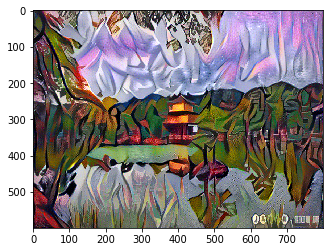

In [57]:
imshow(styled_image)